In [901]:
import pickle
from collections import namedtuple
import pandas as pd
import numpy as np
from importlib import reload
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import datetime

# bench_util module is in the parent directory, because it will be part of
# the production code.  Add the parent directory to the Path so Python can
# import from there
sys.path.insert(0, '../')   
import bench_util as bu
import graph_util as gu

## Unpickle the Dataframe for Preprocessed Utility Data & Make Utility Function Object

In [902]:
# Unpickle the pre-processed DataFrame
df = pickle.load(open('dfu3.pkl', 'rb'))

# Unpickle the raw utility bill DataFrame, which is needed below to make
# the utility function object.
df_raw = pickle.load(open('df_raw.pkl', 'rb'))

df.head()  # the processed data

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
0,03,Electricity,2010,7,Electricity charge,-,24.137931,35.0,0.000000,2011,1,0.000000
1,03,Electricity,2010,7,Electricity charge,kWh,1304.274655,9.5,6656.551724,2011,1,22.712154
2,03,Electricity,2010,8,Electricity charge,-,39.498433,62.0,0.000000,2011,2,0.000000
3,03,Electricity,2010,8,Electricity charge,kWh,4940.646254,31.0,26822.236155,2011,2,91.517470
4,03,Electricity,2010,9,Electricity charge,-,16.363636,27.0,0.000000,2011,3,0.000000


In [903]:
# this is only needed to update any code changes I may have made
# since last importing the module above.
reload(bu) 
reload(gu)

# Make an object that has the various utility functions.
# The object needs access to the raw utility bill DataFrame and the spreadsheet
# containing other application data.
ut = bu.Util(df_raw, '../data/Other_Building_Data.xlsx')

In [904]:
# Testing site.  Final code will loop through all sites
site = 'DIPMP1'

# Energy Use Overview Report - Page 4


In [905]:
# From the main DataFrame, get only the rows for this site, and only get
# the needed columns for this analysis
usage_df1 = df.query('site_id == @site')[['service_type', 'fiscal_year', 'fiscal_mo', 'mmbtu']]
usage_df1.head()

,service_type,fiscal_year,fiscal_mo,mmbtu
27864,Electricity,2011,1,232.491327
27865,Electricity,2011,1,0.000000
27866,Electricity,2011,1,0.000000
27867,Electricity,2011,1,NaN
27868,Electricity,2011,2,423.797568


In [906]:
usage_df1.query("service_type == 'Natural Gas'")

,service_type,fiscal_year,fiscal_mo,mmbtu
28160,Natural Gas,2011,1,1.954452
28161,Natural Gas,2011,1,NaN
28162,Natural Gas,2011,2,39.266710
28163,Natural Gas,2011,2,NaN
28164,Natural Gas,2011,3,16.380701
28165,Natural Gas,2011,3,NaN
28166,Natural Gas,2011,4,4.297794
28167,Natural Gas,2011,4,NaN
28168,Natural Gas,2011,5,4.973654
28169,Natural Gas,2011,5,NaN


In [907]:
usage_df2 = pd.pivot_table(
    usage_df1, 
    values='mmbtu', 
    index=['fiscal_year'], 
    columns=['service_type'],
    aggfunc=np.sum
)

usage_df2 = usage_df2.drop(labels=['Sewer', 'Water'], axis=1)

usage_df2

service_type,Electricity,Natural Gas,Oil #1
fiscal_year,,,
2011,4465.042258,909.064800,6243.551471
2012,4516.043334,7309.068619,668.293467
2013,4760.229306,7748.241853,798.431211
2014,4665.265022,7340.779372,612.212365
2015,4339.763318,4328.011355,2470.153986
2016,5005.284236,0.000000,6761.947500
2017,3335.377486,2686.272000,2137.725000


In [908]:
# Add in columns for the missing services
missing_services = bu.missing_energy_services(usage_df2.columns)
bu.add_columns(usage_df2, missing_services)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam
fiscal_year,,,,
2011,4465.042258,909.064800,6243.551471,0.0
2012,4516.043334,7309.068619,668.293467,0.0
2013,4760.229306,7748.241853,798.431211,0.0
2014,4665.265022,7340.779372,612.212365,0.0
2015,4339.763318,4328.011355,2470.153986,0.0
2016,5005.284236,0.000000,6761.947500,0.0
2017,3335.377486,2686.272000,2137.725000,0.0


In [909]:
# Add a Total column that sums the other columns
usage_df2['Total_Use'] = usage_df2.sum(axis=1)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use
fiscal_year,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486


In [910]:
# Create a list of columns to loop through and calculate percent total energy
usage_cols = list(usage_df2.columns.values)
print (usage_cols)
usage_cols.remove('Total_Use')

for col in usage_cols:
    col_name = col + "_pct_total_energy"
    usage_df2[col_name] = usage_df2[col] / usage_df2.Total_Use

usage_df2

['Electricity', 'Natural Gas', 'Oil #1', 'Steam', 'Total_Use']


service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy
fiscal_year,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0


In [911]:
# Add in degree days
months_present = bu.months_present(usage_df1)
deg_days = ut.degree_days_yearly(months_present, site)
usage_df2['hdd'] = deg_days
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd
fiscal_year,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219


In [912]:
# Add in a column to show the numbers of months present for each year
# This will help to identify partial years.
mo_count = bu.month_count(months_present)
usage_df2['month_count'] = mo_count
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count
fiscal_year,,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10


In [913]:
# Calculate total heat energy and normalized heating usage
usage_df2['total_heat_energy'] = usage_df2['Natural Gas'] + usage_df2['Steam'] + usage_df2['Oil #1']
usage_df2['total_specific_heat_usage'] = usage_df2['total_heat_energy'] * 1000 / usage_df2.hdd
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12,7152.616271,518.230421
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12,7977.362086,643.699031
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12,8546.673064,702.216175
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12,7952.991738,576.220239
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12,6798.165341,548.548805
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12,6761.947500,555.578630
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10,4823.997000,364.929042


In [914]:
# Reverse the DataFrame
usage_df2.sort_index(ascending=False, inplace=True)
usage_df2

service_type,Electricity,Natural Gas,Oil #1,Steam,Total_Use,Electricity_pct_total_energy,Natural Gas_pct_total_energy,Oil #1_pct_total_energy,Steam_pct_total_energy,hdd,month_count,total_heat_energy,total_specific_heat_usage
fiscal_year,,,,,,,,,,,,,
2017,3335.377486,2686.272000,2137.725000,0.0,8159.374486,0.408779,0.329225,0.261996,0.0,13219,10,4823.997000,364.929042
2016,5005.284236,0.000000,6761.947500,0.0,11767.231736,0.425358,0.000000,0.574642,0.0,12171,12,6761.947500,555.578630
2015,4339.763318,4328.011355,2470.153986,0.0,11137.928659,0.389638,0.388583,0.221779,0.0,12393,12,6798.165341,548.548805
2014,4665.265022,7340.779372,612.212365,0.0,12618.256760,0.369723,0.581759,0.048518,0.0,13802,12,7952.991738,576.220239
2013,4760.229306,7748.241853,798.431211,0.0,13306.902370,0.357726,0.582272,0.060001,0.0,12171,12,8546.673064,702.216175
2012,4516.043334,7309.068619,668.293467,0.0,12493.405421,0.361474,0.585034,0.053492,0.0,12393,12,7977.362086,643.699031
2011,4465.042258,909.064800,6243.551471,0.0,11617.658529,0.384332,0.078249,0.537419,0.0,13802,12,7152.616271,518.230421


## Create Energy Usage Overview Graphs

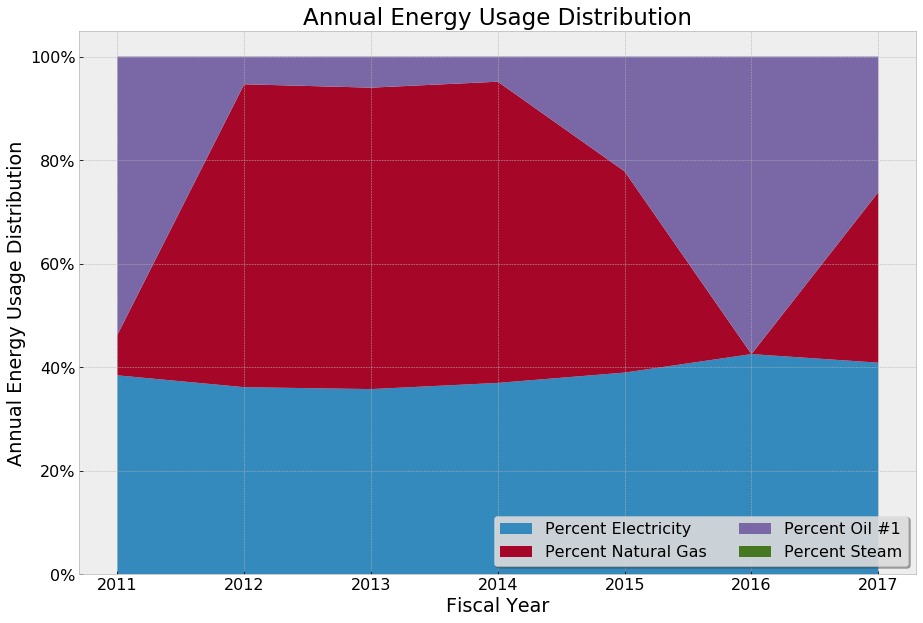

In [915]:
# Reset the index so the fiscal year column can be passed to the graphing function
reset_usage_df2 = usage_df2.reset_index()

file_name = site + "_graph_pg4_g2.png"

# Create the area graph
gu.area_use_distribution(reset_usage_df2, 'fiscal_year', usage_cols, file_name)

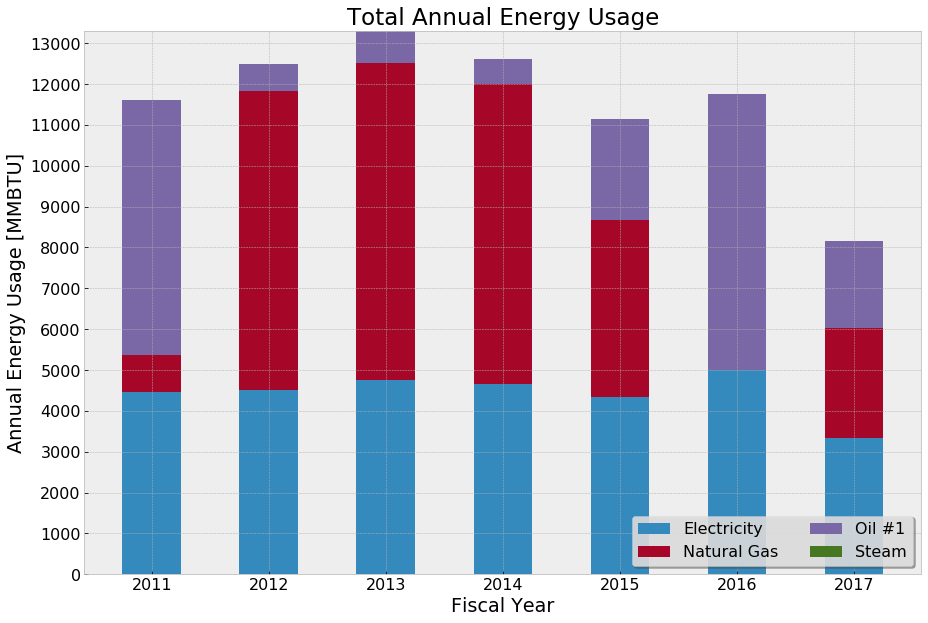

In [916]:
stacked_bar_filename = site + "_graph_pg4_g1.png"

gu.energy_use_stacked_bar(reset_usage_df2, 'fiscal_year', usage_cols, stacked_bar_filename)

In [917]:
# Export the rows of the DataFrame into a list of dictionaries for use
# in the template.  Rename columns to match template variables.
usage_dict = bu.df_to_dictionaries(usage_df2, change_names={'Natural Gas': 'natural_gas', 'Oil #1': 'fuel_oil'})
usage_dict

[{'Electricity': 3335.3774864516131,
  'Electricity_pct_total_energy': 0.4087785763467412,
  'Natural Gas_pct_total_energy': 0.32922523711351531,
  'Oil #1_pct_total_energy': 0.26199618653974338,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 8159.3744864516138,
  'fiscal_year': 2017,
  'fuel_oil': 2137.7249999999999,
  'hdd': 13219.0,
  'month_count': 10.0,
  'natural_gas': 2686.2719999999999,
  'total_heat_energy': 4823.9969999999994,
  'total_specific_heat_usage': 364.92904153112937},
 {'Electricity': 5005.2842360483864,
  'Electricity_pct_total_energy': 0.42535783677268141,
  'Natural Gas_pct_total_energy': 0.0,
  'Oil #1_pct_total_energy': 0.57464216322731854,
  'Steam': 0.0,
  'Steam_pct_total_energy': 0.0,
  'Total_Use': 11767.231736048387,
  'fiscal_year': 2016,
  'fuel_oil': 6761.9474999999993,
  'hdd': 12171.0,
  'month_count': 12.0,
  'natural_gas': 0.0,
  'total_heat_energy': 6761.9474999999993,
  'total_specific_heat_usage': 555.57862952920868},
 {'Electri

# Create Usage Pie Charts

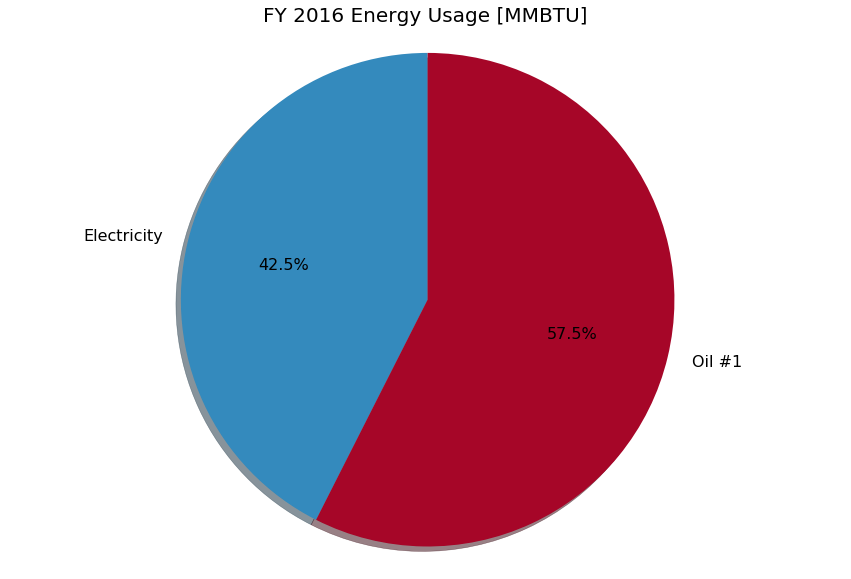

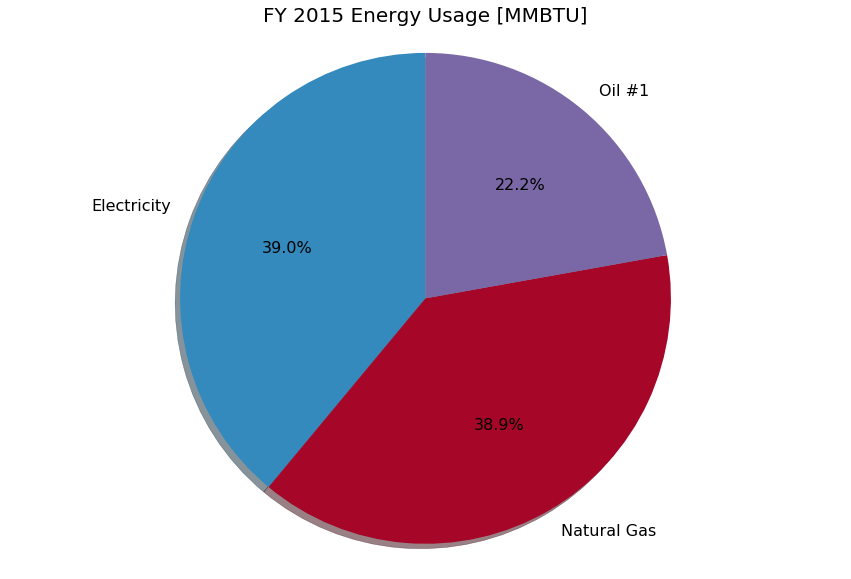

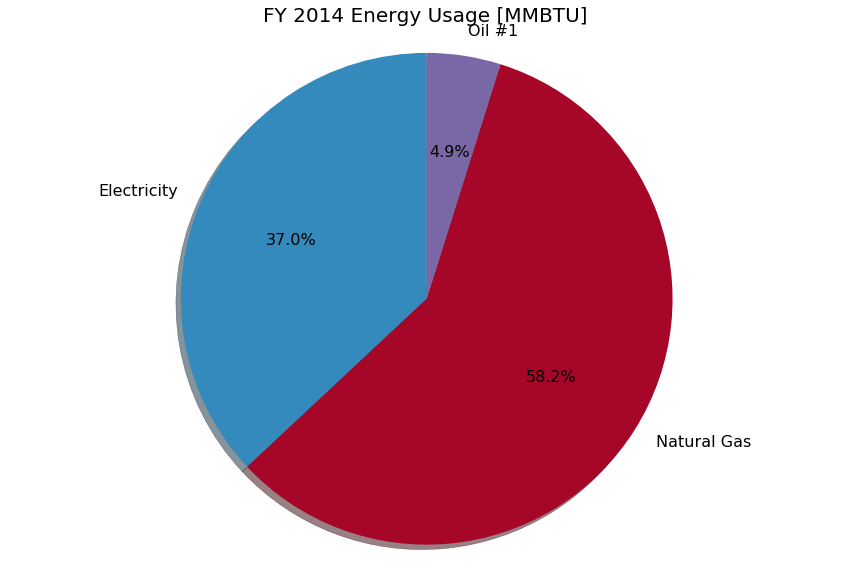

In [918]:
pie_filename = site + "_graph_pg5_"
gu.usage_pie_charts(usage_df2, usage_cols, 1, pie_filename)

# Electrical Usage Analysis - Page 6

In [919]:
site_df = df.query("site_id == @site")
site_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
27864,DIPMP1,Electricity,2010,7,Energy charge,kWh,3055.367586,16.5,68139.310345,2011,1,232.491327
27865,DIPMP1,Electricity,2010,7,KW Charge,kW,0.000000,16.5,158.627586,2011,1,0.000000
27866,DIPMP1,Electricity,2010,7,On peak demand,-,1487.082414,16.5,0.000000,2011,1,0.000000
27867,DIPMP1,Electricity,2010,7,Other Charge,-,6597.433966,16.5,NaN,2011,1,NaN
27868,DIPMP1,Electricity,2010,8,Energy charge,kWh,5569.483929,31.0,124207.962382,2011,2,423.797568


In [920]:
# only look at elecricity records
electric_df = site_df.query("service_type == 'Electricity'")

In [921]:
# Make sure I'm not potentially missing anything with funky unit names
check_df = electric_df.query("usage > 0")
check_df.units.unique()

array(['kWh', 'kW', 'kVAR'], dtype=object)

In [922]:
electric_df = electric_df.query("units == 'kWh' or units == 'kW'")
electric_df.head()

,site_id,service_type,cal_year,cal_mo,item_desc,units,cost,days_served,usage,fiscal_year,fiscal_mo,mmbtu
27864,DIPMP1,Electricity,2010,7,Energy charge,kWh,3055.367586,16.5,68139.310345,2011,1,232.491327
27865,DIPMP1,Electricity,2010,7,KW Charge,kW,0.000000,16.5,158.627586,2011,1,0.000000
27868,DIPMP1,Electricity,2010,8,Energy charge,kWh,5569.483929,31.0,124207.962382,2011,2,423.797568
27869,DIPMP1,Electricity,2010,8,KW Charge,kW,0.000000,31.0,293.287565,2011,2,0.000000
27872,DIPMP1,Electricity,2010,9,Energy charge,kWh,5294.718140,30.0,118080.313480,2011,3,402.890030


In [923]:
electric_df.query("units == 'kWh'")['item_desc'].unique()

array(['Energy charge', 'Utility Charge'], dtype=object)

In [924]:
electric_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Demand Charge',
       'Utility Charge'], dtype=object)

In [925]:
electric_df.to_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\electric_testing.csv")

In [926]:
electric_pivot_monthly = pd.pivot_table(electric_df,
                                        index=['fiscal_year', 'fiscal_mo'], 
                                        columns=['units'],
                                        values='usage',
                                        aggfunc=np.sum)

electric_pivot_monthly.head()

units                          kW            kWh
fiscal_year fiscal_mo                           
2011        1          158.627586   68139.310345
            2          293.287565  124207.962382
            3          307.093469  118080.313480
            4          325.981034  126864.827586
            5          283.015032  113698.836207

In [927]:
electric_pivot_annual = pd.pivot_table(electric_df,
                                       index=['fiscal_year'],
                                       columns=['units'],
                                       values='usage',
                                       aggfunc=np.sum
                                      )
                                       
electric_use_annual = electric_pivot_annual[['kWh']]
electric_use_annual = electric_use_annual.rename(columns={'kWh':'ann_electric_usage_kWh'})
electric_use_annual

units,ann_electric_usage_kWh
fiscal_year,
2011,1.308629e+06
2012,1.323577e+06
2013,1.395143e+06
2014,1.367311e+06
2015,1.271912e+06
2016,1.466965e+06
2017,9.775432e+05


In [928]:
# Get average annual demand usage
electric_demand_avg = electric_pivot_monthly.groupby(['fiscal_year']).mean()
electric_demand_avg = electric_demand_avg[['kW']]
electric_demand_avg = electric_demand_avg.rename(columns={'kW': 'avg_demand_kW'})
electric_demand_avg

units,avg_demand_kW
fiscal_year,
2011,289.213172
2012,265.742687
2013,278.553146
2014,249.558703
2015,257.109245
2016,275.680036
2017,233.681613


In [929]:
# Find annual maximum demand usage
electric_demand_max = electric_pivot_monthly.groupby(['fiscal_year']).max()
electric_demand_max = electric_demand_max[['kW']]
electric_demand_max = electric_demand_max.rename(columns={'kW': 'max_demand_kW'})
electric_demand_max

units,max_demand_kW
fiscal_year,
2011,430.021119
2012,287.280311
2013,303.987857
2014,294.672414
2015,287.567186
2016,294.307489
2017,295.459455


In [930]:
# Combine dataframes
electric_demand_join = pd.merge(electric_demand_max, electric_demand_avg, how='outer', left_index=True, right_index=True)
annual_electric_data = pd.merge(electric_demand_join, electric_use_annual, how='outer', left_index=True, right_index=True)
annual_electric_data

units,max_demand_kW,avg_demand_kW,ann_electric_usage_kWh
fiscal_year,,,
2011,430.021119,289.213172,1.308629e+06
2012,287.280311,265.742687,1.323577e+06
2013,303.987857,278.553146,1.395143e+06
2014,294.672414,249.558703,1.367311e+06
2015,287.567186,257.109245,1.271912e+06
2016,294.307489,275.680036,1.466965e+06
2017,295.459455,233.681613,9.775432e+05


In [931]:
# Add percent change columns
annual_electric_data['usage_pct_change'] = annual_electric_data.ann_electric_usage_kWh.pct_change()
annual_electric_data['avg_demand_pct_change'] = annual_electric_data.avg_demand_kW.pct_change()
annual_electric_data['max_demand_pct_change'] = annual_electric_data.max_demand_kW.pct_change()
annual_electric_data = annual_electric_data.rename(columns={'avg_demand_kW': 'Average kW',
                                                           'ann_electric_usage_kWh': 'Total kWh'})
annual_electric_data

units,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change
fiscal_year,,,,,,
2011,430.021119,289.213172,1.308629e+06,NaN,NaN,NaN
2012,287.280311,265.742687,1.323577e+06,0.011422,-0.081153,-0.331939
2013,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158
2014,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644
2015,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112
2016,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439
2017,295.459455,233.681613,9.775432e+05,-0.333629,-0.152345,0.003914


## Create Electrical Usage Analysis Graphs - Page 6

In [932]:
# Axes labels
ylabel1 = 'Electricity Usage [kWh]'
ylabel2 = 'Electricity Demand [kW]'

stacked_line_file = site + "_graph_pg6_g1.png"

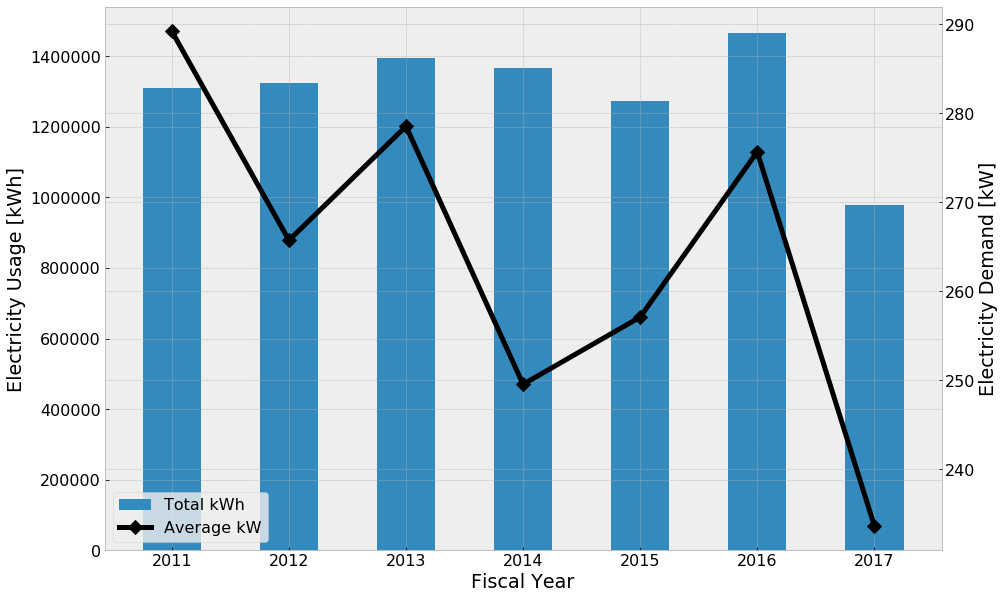

In [933]:
stacked_bar_with_line(annual_electric_data.reset_index(), 'fiscal_year', ['Total kWh'], 'Average kW', 
                      ylabel1, ylabel2, stacked_line_file)

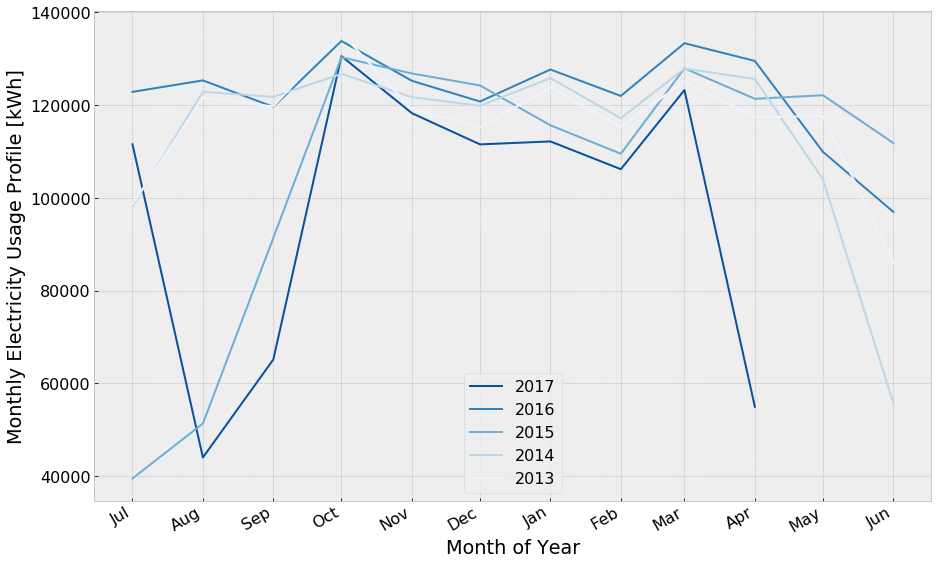

In [934]:
month_profile_filename = site + "_graph_pg6_g2.png"
gu.create_monthly_profile(electric_pivot_monthly, 'kWh', 'Monthly Electricity Usage Profile [kWh]', 'blue',
                         month_profile_filename)

## Electrical Cost Analysis Table - Page 7

In [935]:
# only look at elecricity records
electric_cost_df = site_df.query("service_type == 'Electricity'")

In [936]:
electric_cost_df.item_desc.unique()

array(['Energy charge', 'KW Charge', 'On peak demand', 'Other Charge',
       'Demand Charge', 'Utility Charge', 'kVAR'], dtype=object)

In [937]:
# Costs don't always have units, so split the data into demand charges and usage charges (which includes other charges)
electric_cost_df['cost_categories'] = np.where(electric_cost_df.item_desc.isin(['KW Charge', 'On peak demand', 'Demand Charge']),
                                               'demand_cost', 'usage_cost')

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [938]:
electric_cost_df.to_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\electric_cost_testing.csv")

In [939]:
# Sum costs by demand and usage
electric_annual_cost = pd.pivot_table(electric_cost_df,
                                       index=['fiscal_year'],
                                       columns=['cost_categories'],
                                       values='cost',
                                       aggfunc=np.sum
                                      )
# Create a total column
electric_annual_cost['Total Cost'] = electric_annual_cost.demand_cost + electric_annual_cost.usage_cost

electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost
fiscal_year,,,
2011,31463.674194,187954.246290,219417.920484
2012,34696.867525,225266.682772,259963.550297
2013,38146.446023,236993.286421,275139.732445
2014,39515.007883,211917.016079,251432.023962
2015,40119.548906,187021.650625,227141.199531
2016,45560.764985,199518.886683,245079.651668
2017,33391.390484,152914.001129,186305.391613


In [940]:
# Add percent change columns
electric_annual_cost['usage_cost_pct_change'] = electric_annual_cost.usage_cost.pct_change()
electric_annual_cost['demand_cost_pct_change'] = electric_annual_cost.demand_cost.pct_change()
electric_annual_cost['total_cost_pct_change'] = electric_annual_cost['Total Cost'].pct_change()
electric_annual_cost

cost_categories,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change
fiscal_year,,,,,,
2011,31463.674194,187954.246290,219417.920484,NaN,NaN,NaN
2012,34696.867525,225266.682772,259963.550297,0.198519,0.102760,0.184787
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166
2015,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610
2016,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975
2017,33391.390484,152914.001129,186305.391613,-0.233586,-0.267102,-0.239817


In [941]:
electric_use_and_cost = pd.merge(electric_annual_cost, annual_electric_data, left_index=True, right_index=True, how='outer')
electric_use_and_cost

,demand_cost,usage_cost,Total Cost,usage_cost_pct_change,demand_cost_pct_change,total_cost_pct_change,max_demand_kW,Average kW,Total kWh,usage_pct_change,avg_demand_pct_change,max_demand_pct_change
fiscal_year,,,,,,,,,,,,
2011,31463.674194,187954.246290,219417.920484,NaN,NaN,NaN,430.021119,289.213172,1.308629e+06,NaN,NaN,NaN
2012,34696.867525,225266.682772,259963.550297,0.198519,0.102760,0.184787,287.280311,265.742687,1.323577e+06,0.011422,-0.081153,-0.331939
2013,38146.446023,236993.286421,275139.732445,0.052057,0.099420,0.058378,303.987857,278.553146,1.395143e+06,0.054071,0.048206,0.058158
2014,39515.007883,211917.016079,251432.023962,-0.105810,0.035877,-0.086166,294.672414,249.558703,1.367311e+06,-0.019950,-0.104089,-0.030644
2015,40119.548906,187021.650625,227141.199531,-0.117477,0.015299,-0.096610,287.567186,257.109245,1.271912e+06,-0.069771,0.030256,-0.024112
2016,45560.764985,199518.886683,245079.651668,0.066822,0.135625,0.078975,294.307489,275.680036,1.466965e+06,0.153354,0.072229,0.023439
2017,33391.390484,152914.001129,186305.391613,-0.233586,-0.267102,-0.239817,295.459455,233.681613,9.775432e+05,-0.333629,-0.152345,0.003914


## Create Electrical Cost Analysis Graphs - Page 7

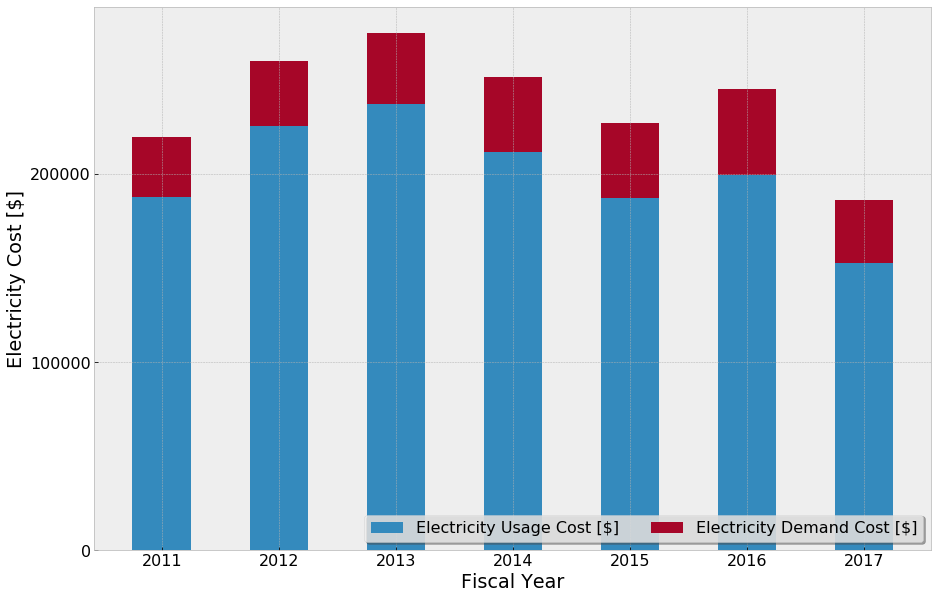

In [942]:
elec_cost_filename = site + "_graph_pg7_g1.png"
renamed_use_and_cost = electric_use_and_cost.rename(columns={'usage_cost':'Electricity Usage Cost [$]',
                                                            'demand_cost':'Electricity Demand Cost [$]'})
gu.create_stacked_bar(renamed_use_and_cost.reset_index(), 'fiscal_year', ['Electricity Usage Cost [$]', 
                                                                          'Electricity Demand Cost [$]'], 
                      'Electricity Cost [$]', elec_cost_filename)

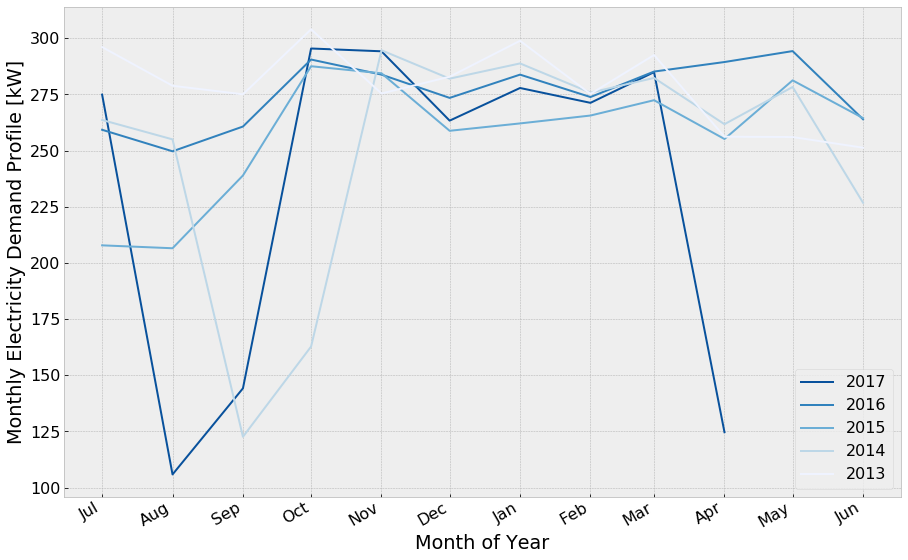

In [943]:
# Create Monthly Profile of Electricity Demand
monthly_demand_filename = site + "_graph_pg7_g2.png"
gu.create_monthly_profile(electric_pivot_monthly, 'kW', 'Monthly Electricity Demand Profile [kW]', 'blue', 
                          monthly_demand_filename)

# Create Heating Usage Analysis Table - Page 8

In [944]:
# Take only needed columns from earlier usage df
heating_usage = usage_df2[['Natural Gas', 'Oil #1', 'Steam', 'hdd', 'month_count', 'total_heat_energy']]
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy
fiscal_year,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341
2014,7340.779372,612.212365,0.0,13802,12,7952.991738
2013,7748.241853,798.431211,0.0,12171,12,8546.673064
2012,7309.068619,668.293467,0.0,12393,12,7977.362086
2011,909.064800,6243.551471,0.0,13802,12,7152.616271


In [945]:
# Add in percent change columns
heating_usage['Oil #1_pct_change'] = heating_usage['Oil #1'].pct_change()
heating_usage['Natural Gas_pct_change'] = heating_usage['Natural Gas'].pct_change()
heating_usage['Steam_pct_change'] = heating_usage['Steam'].pct_change()
heating_usage['total_heat_energy_pct_change'] = heating_usage.total_heat_energy.pct_change()
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change
fiscal_year,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386


In [946]:
# Get the number of gallons, ccf, and 1,000 pounds of district heat by converting MMBTUs using the supplied conversions
heating_usage['Oil #1 Gallons'] = heating_usage['Oil #1'] * 1000000 / ut.fuel_btus_per_unit('Oil #1', 'gallons')
heating_usage['Natural Gas ccf'] = heating_usage['Natural Gas'] * 1000000 / ut.fuel_btus_per_unit('Natural Gas', 'ccf')
heating_usage

C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


## Create Heating Usage Analysis Graphs - Page 8

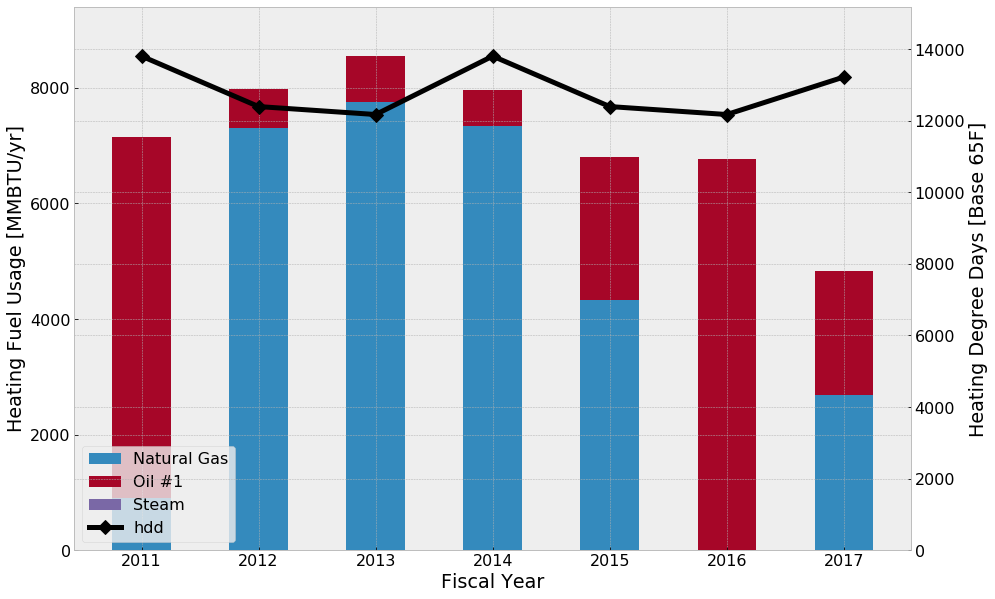

In [947]:
use_with_hdd_filename = site + '_graph_pg8_g1.png'
gu.stacked_bar_with_line(heating_usage.reset_index(), 'fiscal_year', ['Natural Gas', 'Oil #1', 'Steam'], 'hdd',
                        'Heating Fuel Usage [MMBTU/yr]', 'Heating Degree Days [Base 65F]', use_with_hdd_filename)

### Create Monthly Heating Usage dataframe for graph

In [948]:
monthly_heating = pd.pivot_table(usage_df1,
                                values='mmbtu',
                                index=['fiscal_year', 'fiscal_mo'],
                                columns=['service_type'],
                                aggfunc=np.sum
                                )
monthly_heating

service_type           Electricity  Natural Gas       Oil #1  Sewer  Water
fiscal_year fiscal_mo                                                     
2011        1           232.491327     1.954452    98.738372    NaN    NaN
            2           423.797568    39.266710   165.309128    0.0    0.0
            3           402.890030    16.380701   506.870000    0.0    0.0
            4           432.862792     4.297794   780.918750    0.0    0.0
            5           387.940429     4.973654   899.490000    0.0    0.0
            6           366.575512   235.910172   960.076103    0.0    0.0
            7           370.602635   131.921972  1020.090772    0.0    0.0
            8           338.652871    70.967273   756.894375    0.0    0.0
            9           393.901327    43.087273   636.298676    0.0    0.0
            10          393.160092     9.786000   203.815774    0.0    0.0
            11          397.177978    89.679828   153.156760    0.0    0.0
            12          324.989698   260.838972    61.892761    0.0    0.0
2012        1           345.409811   210.826669    73.988389    0.0    0.0
            2           400.015138   281.787431    23.577465    0.0    0.0
            3           395.211129   435.087694    46.517364    0.0    0.0
            4           436.909826   590.624130   100.810312    0.0    0.0
            5           400.769117  1015.978034    67.687358    0.0    0.0
            6           358.723631   866.548514    47.377358    0.0    0.0
            7           346.543829  1238.691038    60.206383    0.0    0.0
            8           355.182141   825.743990    84.431400    0.0    0.0
            9           402.343040   837.836606    42.036222    0.0    0.0
            10          387.328039   478.561794    38.459659    0.0    0.0
            11          391.365205   354.747719    39.741648    0.0    0.0
            12          296.242429   172.635000    43.459909    0.0    0.0
2013        1           336.512250   202.910903    44.996148    0.0    0.0
            2           414.941487   262.674677    44.996148    0.0    0.0
            3           408.448656   382.801364    43.544659    0.0    0.0
            4           462.218278   682.836836    44.996148    0.0    0.0
            5           406.717224   990.921994    51.119148    0.0    0.0
            6           393.281195  1019.501516   170.713125    0.0    0.0
...                            ...          ...          ...    ...    ...
2015        5           432.705202   744.073548    60.867961    0.0    0.0
            6           423.877204   796.373226    62.896893    0.0    0.0
            7           394.553437  1092.491036    67.074735    0.0    0.0
            8           373.636859   590.508964   331.295192    0.0    0.0
            9           436.488935     0.000000   737.919643    0.0    0.0
            10          414.053450     0.000000   498.858312    0.0    0.0
            11          416.682146     0.000000   323.552045    0.0    0.0
            12          381.513883     0.000000   198.450000    0.0    0.0
2016        1           419.162205     0.000000   307.415543    0.0    0.0
            2           427.578907     0.000000   324.890707    0.0    0.0
            3           408.168442     0.000000   403.380000    0.0    0.0
            4           456.565995     0.000000   610.098750    0.0    0.0
            5           427.290630     0.000000   848.390625    0.0    0.0
            6           412.070611     0.000000   948.459375    0.0    0.0
            7           435.612172     0.000000   794.880000    0.0    0.0
            8           416.148845     0.000000   775.110937    0.0    0.0
            9           454.948403     0.000000   701.620312    0.0    0.0
            10          441.933300     0.000000   439.661250    0.0    0.0
            11          374.986080     0.000000   413.398929    0.0    0.0
            12          330.818646     0.000000   194.641071    0.0    0.0
2017        1           3

In [949]:
# Add in columns for the missing energy services
missing_services = bu.missing_energy_services(monthly_heating.columns)
bu.add_columns(monthly_heating, missing_services)

# Drop the non-heating services
monthly_heating = monthly_heating.drop(labels=['Electricity', 'Sewer', 'Water'], axis=1)

# Create a total heating column
monthly_heating['total_heating_energy'] = monthly_heating.sum(axis=1)

monthly_heating

service_type           Natural Gas       Oil #1  Steam  total_heating_energy
fiscal_year fiscal_mo                                                       
2011        1             1.954452    98.738372    0.0            100.692824
            2            39.266710   165.309128    0.0            204.575838
            3            16.380701   506.870000    0.0            523.250701
            4             4.297794   780.918750    0.0            785.216544
            5             4.973654   899.490000    0.0            904.463654
            6           235.910172   960.076103    0.0           1195.986275
            7           131.921972  1020.090772    0.0           1152.012744
            8            70.967273   756.894375    0.0            827.861648
            9            43.087273   636.298676    0.0            679.385949
            10            9.786000   203.815774    0.0            213.601774
            11           89.679828   153.156760    0.0            242.836587
            12          260.838972    61.892761    0.0            322.731733
2012        1           210.826669    73.988389    0.0            284.815057
            2           281.787431    23.577465    0.0            305.364896
            3           435.087694    46.517364    0.0            481.605057
            4           590.624130   100.810312    0.0            691.434443
            5          1015.978034    67.687358    0.0           1083.665393
            6           866.548514    47.377358    0.0            913.925873
            7          1238.691038    60.206383    0.0           1298.897421
            8           825.743990    84.431400    0.0            910.175390
            9           837.836606    42.036222    0.0            879.872828
            10          478.561794    38.459659    0.0            517.021453
            11          354.747719    39.741648    0.0            394.489367
            12          172.635000    43.459909    0.0            216.094909
2013        1           202.910903    44.996148    0.0            247.907051
            2           262.674677    44.996148    0.0            307.670825
            3           382.801364    43.544659    0.0            426.346023
            4           682.836836    44.996148    0.0            727.832984
            5           990.921994    51.119148    0.0           1042.041141
            6          1019.501516   170.713125    0.0           1190.214641
...                            ...          ...    ...                   ...
2015        5           744.073548    60.867961    0.0            804.941510
            6           796.373226    62.896893    0.0            859.270119
            7          1092.491036    67.074735    0.0           1159.565771
            8           590.508964   331.295192    0.0            921.804157
            9             0.000000   737.919643    0.0            737.919643
            10            0.000000   498.858312    0.0            498.858312
            11            0.000000   323.552045    0.0            323.552045
            12            0.000000   198.450000    0.0            198.450000
2016        1             0.000000   307.415543    0.0            307.415543
            2             0.000000   324.890707    0.0            324.890707
            3             0.000000   403.380000    0.0            403.380000
            4             0.000000   610.098750    0.0            610.098750
            5             0.000000   848.390625    0.0            848.390625
            6             0.000000   948.459375    0.0            948.459375
            7             0.000000   794.880000    0.0            794.880000
            8             0.000000   775.110937    0.0            775.110937
            9             0.000000   701.620312    0.0            701.620312
            10            0.000000   439.661250    0.0            439.661250
            11            0.000000   413.398929    0.0            413.398

In [951]:
print (months_present)

[(2011, 1), (2011, 2), (2011, 3), (2011, 4), (2011, 5), (2011, 6), (2011, 7), (2011, 8), (2011, 9), (2011, 10), (2011, 11), (2011, 12), (2012, 1), (2012, 2), (2012, 3), (2012, 4), (2012, 5), (2012, 6), (2012, 7), (2012, 8), (2012, 9), (2012, 10), (2012, 11), (2012, 12), (2013, 1), (2013, 2), (2013, 3), (2013, 4), (2013, 5), (2013, 6), (2013, 7), (2013, 8), (2013, 9), (2013, 10), (2013, 11), (2013, 12), (2014, 1), (2014, 2), (2014, 3), (2014, 4), (2014, 5), (2014, 6), (2014, 7), (2014, 8), (2014, 9), (2014, 10), (2014, 11), (2014, 12), (2015, 1), (2015, 2), (2015, 3), (2015, 4), (2015, 5), (2015, 6), (2015, 7), (2015, 8), (2015, 9), (2015, 10), (2015, 11), (2015, 12), (2016, 1), (2016, 2), (2016, 3), (2016, 4), (2016, 5), (2016, 6), (2016, 7), (2016, 8), (2016, 9), (2016, 10), (2016, 11), (2016, 12), (2017, 1), (2017, 2), (2017, 3), (2017, 4), (2017, 5), (2017, 6), (2017, 7), (2017, 8), (2017, 9), (2017, 10)]


In [952]:
# Identify partial years through the use of the month_count utility
reset_monthly_heating = monthly_heating.reset_index()
months_present = bu.months_present(reset_monthly_heating)
mo_count = bu.month_count(months_present)
mo_count_df = pd.DataFrame(mo_count)
mo_count_df

,month
year,
2011,12
2012,12
2013,12
2014,12
2015,12
2016,12
2017,10


In [953]:
# Only send records for full years to graphing function
reset_monthly_heating = pd.merge(reset_monthly_heating, mo_count_df, left_on='fiscal_year', right_index=True, how='left')
full_year_monthly_heating = reset_monthly_heating.query("month == 12")
full_year_monthly_heating = full_year_monthly_heating.set_index(['fiscal_year', 'fiscal_mo'])
full_year_monthly_heating

,fiscal_year,fiscal_mo,Natural Gas,Oil #1,Steam,total_heating_energy,month
0,2011,1,1.954452,98.738372,0.0,100.692824,12
1,2011,2,39.266710,165.309128,0.0,204.575838,12
2,2011,3,16.380701,506.870000,0.0,523.250701,12
3,2011,4,4.297794,780.918750,0.0,785.216544,12
4,2011,5,4.973654,899.490000,0.0,904.463654,12
5,2011,6,235.910172,960.076103,0.0,1195.986275,12
6,2011,7,131.921972,1020.090772,0.0,1152.012744,12
7,2011,8,70.967273,756.894375,0.0,827.861648,12
8,2011,9,43.087273,636.298676,0.0,679.385949,12
9,2011,10,9.786000,203.815774,0.0,213.601774,12


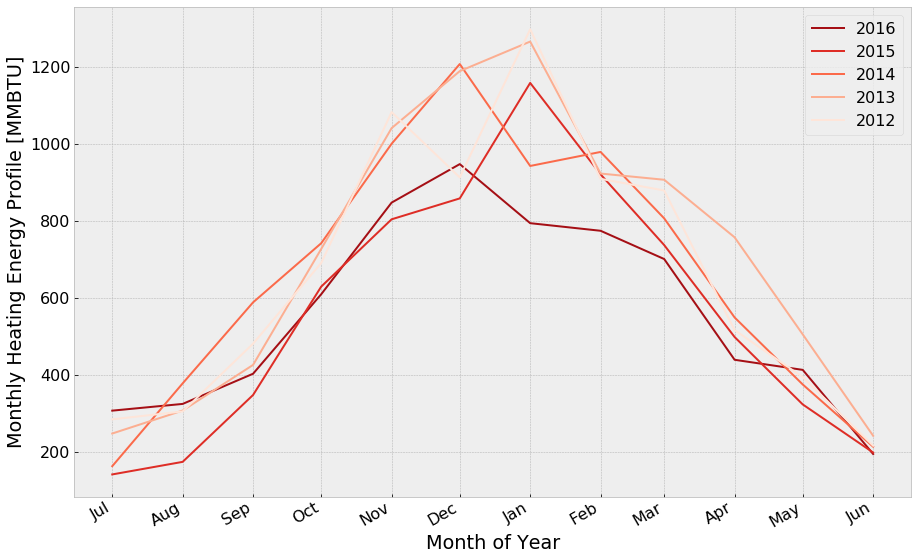

In [955]:
heat_profile_filename = site + '_graph_pg8_g2.png'
gu.create_monthly_profile(full_year_monthly_heating, 'total_heating_energy', "Monthly Heating Energy Profile [MMBTU]", 'red',
                          heat_profile_filename)

## Heating Cost Analysis Table - Page 9

In [967]:
# Import df that I exported from "alan_report_pages".  This can be removed once code is combined
df2 = pd.read_csv(r"C:\Users\dustin\Google Drive\FNSB Data Analysis\data_from_alan_report_pages_df2.csv")

# Use only necessary columns
heating_cost = df2[['fiscal_year', 'Natural Gas', 'Oil #1', 'Steam', 'Total', 'pct_change']]

# Change column names so they aren't the same as the heating usage dataframe
heating_cost = heating_cost.rename(columns={'Natural Gas':'Natural Gas Cost',
                                           'Oil #1': 'Oil #1 Cost',
                                           'Steam': 'Steam Cost',
                                           'Total': 'Total Heat Cost',
                                           'pct_change': 'Total Cost % Change'})
heating_cost

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN


In [958]:
heating_usage

service_type,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
fiscal_year,,,,,,,,,,,,
2017,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
2016,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2015,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
2014,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
2013,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
2012,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
2011,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


In [968]:
# Combine the heating cost and heating use dataframes
heating_cost_and_use = pd.merge(heating_cost, heating_usage, left_on='fiscal_year', right_index=True, how='outer')
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,month_count,total_heat_energy,Oil #1_pct_change,Natural Gas_pct_change,Steam_pct_change,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,10,4823.997000,NaN,NaN,NaN,NaN,15835.000000,26336.000000
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,12,6761.947500,2.163151,-1.000000,NaN,0.401731,50088.500000,0.000000
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,12,6798.165341,-0.634698,inf,NaN,0.005356,18297.436937,42431.483871
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,12,7952.991738,-0.752156,0.696109,NaN,0.169873,4534.906411,71968.425220
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,12,8546.673064,0.304174,0.055507,NaN,0.074649,5914.305263,75963.155425
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,12,7977.362086,-0.162992,-0.056680,NaN,-0.066612,4950.321977,71657.535484
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,12,7152.616271,8.342530,-0.875625,NaN,-0.103386,46248.529412,8912.400000


In [969]:
# Create percent change columns
heating_cost_and_use['oil_cost_pct_change'] = heating_cost_and_use['Oil #1 Cost'].pct_change()
heating_cost_and_use['natural_gas_cost_pct_change'] = heating_cost_and_use['Natural Gas Cost'].pct_change()
heating_cost_and_use['steam_cost_pct_change'] = heating_cost_and_use['Steam Cost'].pct_change()

In [971]:
# Create unit cost columns
heating_cost_and_use['oil_unit_cost'] = heating_cost_and_use['Oil #1 Cost'] / heating_cost_and_use['Oil #1']
heating_cost_and_use['natural_gas_unit_cost'] = heating_cost_and_use['Natural Gas Cost'] / heating_cost_and_use['Natural Gas']
heating_cost_and_use['steam_unit_cost'] = heating_cost_and_use['Steam Cost'] / heating_cost_and_use['Steam']
heating_cost_and_use['building_unit_heat_cost'] = heating_cost_and_use['Total Heat Cost'] / heating_cost_and_use.total_heat_energy
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,...,NaN,15835.000000,26336.000000,NaN,NaN,NaN,13.578957,19.855384,NaN,61.048158
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,...,0.401731,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,...,-0.103386,46248.529412,8912.400000,7.021588,-0.872243,NaN,22.292643,22.993704,NaN,58.548124


In [972]:
# Remove all columns not needed for the Heating Cost Analysis Table
heating_cost_and_use[['fiscal_year', 'Oil #1 Cost', 'oil_cost_pct_change', 'Natural Gas Cost', 'natural_gas_cost_pct_change',
                     'Steam Cost', 'steam_cost_pct_change', 'oil_unit_cost', 'natural_gas_unit_cost', 'steam_unit_cost',
                     'building_unit_heat_cost', 'Total Heat Cost', 'Total Cost % Change']]
heating_cost_and_use

,fiscal_year,Natural Gas Cost,Oil #1 Cost,Steam Cost,Total Heat Cost,Total Cost % Change,Natural Gas,Oil #1,Steam,hdd,...,total_heat_energy_pct_change,Oil #1 Gallons,Natural Gas ccf,oil_cost_pct_change,natural_gas_cost_pct_change,steam_cost_pct_change,oil_unit_cost,natural_gas_unit_cost,steam_unit_cost,building_unit_heat_cost
0,2017,53336.961562,29028.075000,0.0,294496.131925,-0.211853,2686.272000,2137.725000,0.0,13219,...,NaN,15835.000000,26336.000000,NaN,NaN,NaN,13.578957,19.855384,NaN,61.048158
1,2016,690.478276,90349.225000,0.0,373656.286356,-0.090911,0.000000,6761.947500,0.0,12171,...,0.401731,50088.500000,0.000000,2.112477,-0.987054,NaN,13.361421,inf,NaN,55.258679
2,2015,97125.406774,48709.171396,0.0,411022.962057,-0.127236,4328.011355,2470.153986,0.0,12393,...,0.005356,18297.436937,42431.483871,-0.460879,139.663957,NaN,19.719083,22.441116,NaN,60.460866
3,2014,164359.650963,15747.134827,0.0,470943.816735,-0.073340,7340.779372,612.212365,0.0,13802,...,0.169873,4534.906411,71968.425220,-0.676711,0.692242,NaN,25.721687,22.389946,NaN,59.215932
4,2013,173104.449037,20369.326596,0.0,508216.253007,0.048115,7748.241853,798.431211,0.0,12171,...,0.074649,5914.305263,75963.155425,0.293526,0.053205,NaN,25.511686,22.341126,NaN,59.463636
5,2012,163613.406387,17351.334533,0.0,484885.747289,0.157875,7309.068619,668.293467,0.0,12393,...,-0.066612,4950.321977,71657.535484,-0.148164,-0.054828,NaN,25.963645,22.384987,NaN,60.782718
6,2011,20902.767000,139185.262647,0.0,418772.262631,NaN,909.064800,6243.551471,0.0,13802,...,-0.103386,46248.529412,8912.400000,7.021588,-0.872243,NaN,22.292643,22.993704,NaN,58.548124
